## Importing and splitting the data

In [58]:
import csv
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

Import the dataset

In [59]:
csvfile = 'polymers_dataset.csv'
rows = []
fingerprints = []
nonzero_count = 0
with open(csvfile, 'r') as csv_file:
     csv_reader = csv.reader(csv_file, dialect='excel', delimiter=',')
     line_count = 0
     for row in csv_reader:
          if line_count == 0:
               pass
          else:
               rows.append([val for val in row[:3]])
               fingerprints.append([int(val) for val in row[3:]])
          line_count += 1


Printing a certain index with data

In [60]:
nonzero_count = 0
print('Number of polymers: ', len(rows))
index = 411 #Change this value to see the data
print(f"Index {rows[index][0]} with SMILES {rows[index][1]}")
print('Label: ', rows[index][2])
print('Fingerprint: ',fingerprints[index])
for i in range(2048):
     if fingerprints[index][i] != 0:
          nonzero_count += 1
print('Fingerprints == 1: ', nonzero_count)

Number of polymers:  20609
Index 411 with SMILES O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)([H])[C@@]1([H])N[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([H])[C@]1([H])O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)([H])[C@]1([H])O
Label:  oligosaccharide
Fingerprint:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

Splitting the data into training, validation and testing data

In [61]:
line_count = len(rows)
indices = np.arange(line_count)
indices_fin = np.arange(len(fingerprints))
np.random.shuffle(indices)
split_train = 80
split_validation = 10
split_test = 10
train_end = int(line_count * split_train / 100)
val_end = train_end + int(line_count * split_validation / 100)
train_end_fin = int(len(fingerprints) * split_train / 100)
val_end_fin = train_end_fin + int(len(fingerprints) * split_validation / 100)
# Split data
train = [rows[i] for i in indices[:train_end]]
validation = [rows[i] for i in indices[train_end:val_end]]
test = [rows[i] for i in indices[val_end:]]
# Fingerprint data
fin_rows = [fingerprints[i] for i in indices_fin[:]]
fin_train = [fingerprints[i] for i in indices_fin[:train_end_fin]]
fin_validation = [fingerprints[i] for i in indices_fin[train_end_fin:val_end_fin]]
fin_test = [fingerprints[i] for i in indices_fin[val_end_fin:]]
#Labels data
label_train = [train[i][2] for i in range(len(train))]
label_validation = [validation[i][2] for i in range(len(validation))]
label_test = [test[i][2] for i in range(len(test))]
label = [rows[i][2] for i in range(len(train+validation+test))]
#Change strings to integers
for i in range(len(label_train)):
    if label_train[i] == 'peptide':
        label_train[i] = 0
    if label_train[i] == 'plastic':
        label_train[i] = 1
    if label_train[i] == 'oligosaccharide':
        label_train[i] = 2
for i in range(len(label_validation)):
    if label_validation[i] == 'peptide':
        label_validation[i] = 0
    if label_validation[i] == 'plastic':
        label_validation[i] = 1
    if label_validation[i] == 'oligosaccharide':
        label_validation[i] = 2
for i in range(len(label_test)):
    if label_test[i] == 'peptide':
        label_test[i] = 0
    if label_test[i] == 'plastic':
        label_test[i] = 1
    if label_test[i] == 'oligosaccharide':
        label_test[i] = 2
for i in range(len(label)):
    if label[i] == 'peptide':
        label[i] = 0
    if label[i] == 'plastic':
        label[i] = 1
    if label[i] == 'oligosaccharide':
        label[i] = 2
print(len(train),len(validation),len(test),len(train)+len(validation)+len(test),len(rows))
print(test[len(test)-1])
print(label_validation)

16487 2060 2062 20609 20609
['3468', 'OC(=O)[C@]([H])(CC1=CNC2=C1C=CC=C2)NC(=O)[C@]([H])(CCC(N)=O)NC(=O)[C@]([H])(CC1=CNC=N1)NC(=O)[C@]([H])(CCC(O)=O)NC(=O)[C@]([H])(C)NC(=O)[C@]([H])(CC(O)=O)NC(=O)[C@]([H])([H])N', 'peptide']
[2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 0, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 2, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1, 0, 1, 1, 2, 1, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0

Draw the selected molecule

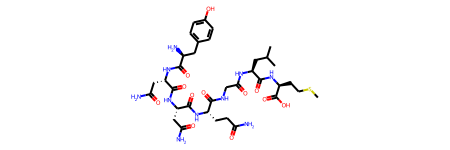

In [62]:
mol = Chem.MolFromSmiles(train[index][1])
mol

Calculate the probabilities of the 3 labels

In [63]:
sugar = 0
plastic = 0
peptide = 0

for i in range(len(rows)):
    if rows[i][2] == 'peptide':
        peptide += 1
    elif rows[i][2] == 'plastic':
        plastic += 1
    elif rows[i][2] == 'oligosaccharide':
        sugar += 1

p_sugar = sugar / len(rows)
p_plastic = plastic / len(rows)
p_peptide = peptide / len(rows)
print(f"Probability of peptide, plastic or sugar for the label: {p_peptide:6.3f}, {p_plastic:6.3f}, {p_sugar:6.3f}.")
print('Total probability: ',p_sugar+p_plastic+p_peptide)


Probability of peptide, plastic or sugar for the label:  0.333,  0.330,  0.337.
Total probability:  1.0


## Make a Neural network to identify polymers

Importing libraries

In [64]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

Prepare the data for the training, validation and testing data sets

In [65]:
from sklearn.model_selection import train_test_split

NUM_CLASSES = 3
NUM_FEATURES = 2048
RANDOM_SEED = 42
X_blob = torch.FloatTensor(fin_rows).type(torch.float)
y_blob = torch.FloatTensor(label).type(torch.LongTensor)
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)


Make the model with three layers: the 2048 fingerprints to a 128 hidden layer, then that layer goes to a 16 layer and then the last gives the 3 labels. The activation function used are ReLu and softmax.

In [66]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=128),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=128, out_features=16),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=16, out_features=output_features), # how many classes are there?
            nn.Softmax(dim=1)

        )
    
    def forward(self, x):
        x = self.linear_layer_stack(x)
        return x

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=64).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

Settings for the Neural Network such as the criterion, optimizer, number of epochs

In [67]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [68]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Training and validation loop

In [69]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)
      
    if test_acc > 99.99:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 
       break
      

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.09686, Acc: 54.76% | Test Loss: 1.09622, Test Acc: 60.82%
Epoch: 10 | Loss: 1.08811, Acc: 67.30% | Test Loss: 1.08719, Test Acc: 65.99%
Epoch: 20 | Loss: 1.07288, Acc: 67.50% | Test Loss: 1.07136, Test Acc: 66.16%
Epoch: 30 | Loss: 1.04372, Acc: 68.25% | Test Loss: 1.04048, Test Acc: 67.03%
Epoch: 40 | Loss: 0.97964, Acc: 69.07% | Test Loss: 0.97238, Test Acc: 68.10%
Epoch: 50 | Loss: 0.86221, Acc: 72.12% | Test Loss: 0.85521, Test Acc: 72.56%
Epoch: 60 | Loss: 0.77634, Acc: 91.93% | Test Loss: 0.77650, Test Acc: 93.72%
Epoch: 70 | Loss: 0.73360, Acc: 99.69% | Test Loss: 0.73552, Test Acc: 99.78%
Epoch: 75 | Loss: 0.71599, Acc: 99.98% | Test Loss: 0.71755, Test Acc: 100.00%
